# 小组成员
 1. 信息2301, 2310650118, 洪菁曼 （组长）
 2. 信息2302, 2310650219, 安雨琪

# 工作日志
## 问题一（安雨琪）
1. 2026-01-03 数据预处理 主要是将附件2各行重命名转换日期，附件一附件二通过单品编码的主键合并数据（数据库）
     * 预处理时发现反复运行合并数据会报错，删除已有重复列解决这个问题
2. 2026-01-03 基础分析 （1）将单品销售量前十列出 （2）6个品类年度分析、季度分析 （3）周末对比平常
     * 基础分析的一些方法不确定要不要做两个人讨论了一下决定从年、季度、周末入手
3. 2026-01-03 聚类分析 进行品类的聚类分组：分了三个类 、随机森林（回归分析）来说明各品类之间的相关关系；用spearman来进行销量和价格的相关性分析
     * 相关分析，一开始只采用了聚类分析和随机森林，发现描述的不够准确不太适合这类问题，进而选择用spearman和person。因为规律大概率不是线性的 所以用的spearman。spearman中一开始写的冗余代码太多一直在重复。后改进了写法，用封装的函数来优化代码

 智能商务数据分析实践  课程考核题目及要求

任务要求：
选题二选一完成，分组2~3人一组。
独立实践报告采用Jupyter写，最后在线提交notebook原文件以及其导出的PDF文件，无需包含原始数据，打包成ZIP包。
Jupyter笔记的的第一个Markdown单元格内必须写成员的班级、学号、姓名

报告的第二个Markdown单元格，写工作日志，至少4条以上，内容写标志性、自己做过努力的、跳过的坑。

1. 202x-xx-xx 对数据进行了...统计分析
1. 202x-xx-xx 补充了...分析
1. 202x-xx-xx 采用...交叉验证对选择模型..
1. ...
报告必须有相应的分析或说明文字，需要必要的完整中间过程（程序和输出结果）
报告最多分两级标题（章和节）
成员多于1人的小组，在报告每个第二级（节）的末尾以陈述方式说明成员的工作。

> 张三承担...完成...


选题2：蔬菜类商品的自动定价与补货决策问题

问题：
在生鲜商超中，一般蔬菜类商品的保鲜期都比较短，且品相随销售时间的增加而变差，大部分品种如当日未售出，隔日就无法再售。因此，商超通常会根据各商品的历史销售和需求情况每天进行补货。

由于商超销售的蔬菜品种众多、产地不尽相同，而蔬菜的进货交易时间通常在凌晨 3:00-4:00，为此商家须在不确切知道具体单品和进货价格的情况下，做出当日各蔬菜品类的补货决策。蔬菜的定价一般采用“成本加成定价”方法，商超对运损和品相变差的商品通常进行打折销售。可靠的市场需求分析，对补货决策和定价决策尤为重要。从需求侧来看，蔬菜类商品的销售量与时间往往存在一定的关联关系；从供给侧来看，蔬菜的供应品种在4月至10月较为丰富，商超销售空间的限制使得合理的销售组合变得极为重要。

附件1给出了某商超经销的6个蔬菜品类的商品信息；附件2和附件3分别给出了该商超2020年7月1日至2023年6月30日各商品的销售流水明细与批发价格的相关数据；附件4给出了各商品近期的损耗率数据。

请根据附件和实际情况建立数学模型解决以下问题：
问题1 蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。
问题2 考虑商超以品类为单位做补货计划，请分析各蔬菜品类的销售总量与成本加成定价的关系，并给出各蔬菜品类未来一周(2023 年 7 月 1-7 日)的日补货总量和定价策略，使得商超收益最大。
问题3 因蔬菜类商品的销售空间有限，商超希望进一步制定单品的补货计划，要求可售单品总数控制在 27-33 个，且各单品订购量满足最小陈列量 2.5 千克的要求。根据 2023 年 6 月 24-30 日的可售品种，给出 7 月 1 日的单品补货量和定价策略，在尽量满足市场对各品类蔬菜商品需求的前提助，请给出你们的意见和理由。

数据文件：
附件1 数据文件是6个蔬菜品类的商品信息
附件2 销售流水明细数据
附件3 蔬菜类商品的批发价格
附件4 蔬菜类商品的近期损耗率
附件说明：
附件1中部分单品名称包含的数字编号表示不同的供应来源。
附件4中的损耗率反映了近期商品的损耗情况，通过近期盘点周期的数据计算得到。


# 数据预处理

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import warnings
import os
import seaborn as sns
warnings.filterwarnings('ignore')

# 设置中文
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [18]:
def smart_loader(file_path):
    """智能加载器：读取 Excel -> 优化数据类型 -> 保存 Parquet 缓存"""

    cache_file = os.path.splitext(file_path)[0] + '.parquet'
    
    # 1. 命中缓存：直接读取
    if os.path.exists(cache_file):
        print(f"读取缓存: {cache_file}")
        return pd.read_parquet(cache_file)
    
    # 2. 未命中缓存：读取原始文件
    print(f"读取原始文件: {file_path}")
    if file_path.endswith('.xlsx') or file_path.endswith('.xls'):
        df = pd.read_excel(file_path)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)

    # 字符串 -> 分类    
    for col in df.select_dtypes(include=['object']).columns:
            num_unique_values = len(df[col].unique())
            num_total_values = len(df)
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')
    # 日期列转换
    if '销售日期' in df.columns:
        df['销售日期'] = pd.to_datetime(df['销售日期'])

    # 3. 保存为 Parquet
    df.to_parquet(cache_file, engine='pyarrow')
    print(f"已创建缓存文件: {cache_file}")
    
    return df

# 使用方式
# df = smart_loader('your_file.xlsx')

# 问题1
蔬菜类商品不同品类或不同单品之间可能存在一定的关联关系，请分析蔬菜各品类及单品销售量的分布规律及相互关系。

品类：分类名称

In [19]:
try:
    raw_sales = smart_loader('./选题2-蔬菜自动定价与补货决策/附件2.xlsx')
    raw_category = smart_loader('./选题2-蔬菜自动定价与补货决策/附件1.xlsx')
except Exception as e:
    print(f" 读取失败: {e}")
    exit()

读取缓存: ./选题2-蔬菜自动定价与补货决策/附件2.parquet
读取缓存: ./选题2-蔬菜自动定价与补货决策/附件1.parquet


In [39]:
def process_sales_pipeline(raw_sales, raw_category):
    """
    全流程处理：原始流水 -> 清洗合并 -> 价格检查 -> 日级聚合
    """
    # ---------------------------------------------------------
    df = raw_sales.copy()
    # 规范化列名
    df.columns = ['销售日期', '扫码时间', '单品编码', '销量', '单价', '销售类型', '是否打折']
    df['日期'] = pd.to_datetime(df['销售日期'])
    
    # 过滤：只保留销售记录，且销量大于0（剔除退货和异常数据）
    df = df[(df['销售类型'] == '销售') & (df['销量'] > 0)]
    
    # 合并商品信息
    category_info = raw_category[['单品编码', '分类名称', '单品名称']].drop_duplicates()
    df = pd.merge(df, category_info, on='单品编码', how='left')
    df['分类名称'] = df['分类名称'].astype(str).replace('nan', '未知品类')
    
    print(f"1.基础清洗完成: {len(df)} 条有效记录")

    # ---------------------------------------------------------
    print("\n 2.正在检查价格一致性...")
    # 统计每天每个单品有多少个不同的单价
    price_counts = df.groupby(['日期', '单品编码'])['单价'].nunique()
    inconsistent_mask = price_counts > 1
    
    if inconsistent_mask.any():
        num_issues = inconsistent_mask.sum()
        total_groups = len(price_counts)
        print(f"    发现价格差异: 在 {total_groups} 个(天/单品)组合中，有 {num_issues} 个存在一日多价情况。")
        print(f"      比例: {num_issues/total_groups:.2%}")
        print("      >> 处理策略: 将自动计算 '加权平均单价' (总金额/总销量) 以消除差异。")
    else:
        print("    所有单品每日价格唯一。")

    # ---------------------------------------------------------
    print("\n 3.正在执行日数据...")
    
    # 预计算销售额
    df['销售额'] = df['销量'] * df['单价']
    
    # --- A. 生成单品日数据 (用于 Q1单品分析 和 Q3) ---
    df_sku_daily = df.groupby(['日期', '分类名称', '单品编码', '单品名称']).agg({
        '销量': 'sum',
        '销售额': 'sum'
    }).reset_index()
    # 计算加权均价
    df_sku_daily['加权单价'] = df_sku_daily['销售额'] / df_sku_daily['销量']
    
    # --- B. 生成品类日数据 (用于 Q1品类分析 和 Q2) ---
    df_cat_daily = df.groupby(['日期', '分类名称']).agg({
        '销量': 'sum',
        '销售额': 'sum'
    }).reset_index()
    df_cat_daily['加权单价'] = df_cat_daily['销售额'] / df_cat_daily['销量']
    
    # ---------------------------------------------------------
    def get_season(month):
        if month in [3, 4, 5]:
            return '春季'
        elif month in [6, 7, 8]:
            return '夏季'
        elif month in [9, 10, 11]:
            return '秋季'
        else: # 12, 1, 2
            return '冬季'
    for data in [df_sku_daily, df_cat_daily]:
        data['年份'] = data['日期'].dt.year
        data['月份'] = data['日期'].dt.month
        data['季度'] = data['日期'].dt.quarter
        data['星期'] = data['日期'].dt.weekday # 0-6
        data['是否周末'] = data['星期'].isin([5, 6])
        
        data['季节'] = data['月份'].apply(get_season)
        data['季节'] = pd.Categorical(data['季节'], categories=['春季', '夏季', '秋季', '冬季'], ordered=True)
    
    print(f" 处理完毕!")
    print(f"   单品日数据: {df_sku_daily.shape}")
    print(f"   品类日数据: {df_cat_daily.shape}")
    
    return df_sku_daily, df_cat_daily

In [40]:
df_sku_daily, df_cat_daily = process_sales_pipeline(raw_sales, raw_category)

1.基础清洗完成: 878042 条有效记录

 2.正在检查价格一致性...
    发现价格差异: 在 46595 个(天/单品)组合中，有 7076 个存在一日多价情况。
      比例: 15.19%
      >> 处理策略: 将自动计算 '加权平均单价' (总金额/总销量) 以消除差异。

 3.正在执行日数据...
 处理完毕!
   单品日数据: (46595, 13)
   品类日数据: (6474, 11)


In [41]:
df_sku_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46595 entries, 0 to 46594
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      46595 non-null  datetime64[ns]
 1   分类名称    46595 non-null  object        
 2   单品编码    46595 non-null  int64         
 3   单品名称    46595 non-null  object        
 4   销量      46595 non-null  float64       
 5   销售额     46595 non-null  float64       
 6   加权单价    46595 non-null  float64       
 7   年份      46595 non-null  int32         
 8   月份      46595 non-null  int32         
 9   季度      46595 non-null  int32         
 10  星期      46595 non-null  int32         
 11  是否周末    46595 non-null  bool          
 12  季节      46595 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int32(4), int64(1), object(2)
memory usage: 3.3+ MB


In [42]:
df_sku_daily.head()

,日期,分类名称,单品编码,单品名称,销量,销售额,加权单价,年份,月份,季度,星期,是否周末,季节
0,2020-07-01,水生根茎类,102900005118824,高瓜(1),4.119,41.1900,10.0,2020,7,3,2,False,夏季
1,2020-07-01,水生根茎类,102900051000944,洪湖藕带,0.731,29.0938,39.8,2020,7,3,2,False,夏季
2,2020-07-01,花叶类,102900005115762,苋菜,6.841,41.0460,6.0,2020,7,3,2,False,夏季
3,2020-07-01,花叶类,102900005115779,云南生菜,41.966,335.7280,8.0,2020,7,3,2,False,夏季
4,2020-07-01,花叶类,102900005115786,竹叶菜,11.352,68.1120,6.0,2020,7,3,2,False,夏季


In [43]:
df_cat_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6474 entries, 0 to 6473
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   日期      6474 non-null   datetime64[ns]
 1   分类名称    6474 non-null   object        
 2   销量      6474 non-null   float64       
 3   销售额     6474 non-null   float64       
 4   加权单价    6474 non-null   float64       
 5   年份      6474 non-null   int32         
 6   月份      6474 non-null   int32         
 7   季度      6474 non-null   int32         
 8   星期      6474 non-null   int32         
 9   是否周末    6474 non-null   bool          
 10  季节      6474 non-null   category      
dtypes: bool(1), category(1), datetime64[ns](1), float64(3), int32(4), object(1)
memory usage: 367.0+ KB


## 基础分析

In [44]:
# Q1.1 销售量的分布规律 (基于日数据)
def analyze_distribution(df_daily, level_name='分类名称'):
    """画箱线图看分布，画折线图看趋势"""
    
    # 1. 箱线图
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=level_name, y='销量', data=df_daily)
    plt.yscale('log') # 销量差异大，建议用对数坐标
    plt.title(f'各{level_name}日销量分布 (Log Scale)')
    plt.xticks(rotation=45)
    plt.show()
    
    # 2. 月度趋势 (聚合到月看大趋势)
    df_monthly = df_daily.groupby([pd.Grouper(key='日期', freq='M'), level_name])['销量'].sum().reset_index()
    
    plt.figure(figsize=(14, 6))
    sns.lineplot(x='日期', y='销量', hue=level_name, data=df_monthly, marker='o')
    plt.title(f'各{level_name}月度销售趋势（前10）')
    plt.show()


# Q1.2 相互关系分析 (相关性热力图)
# ==========================================
def analyze_correlation(df_daily, level_name='分类名称'):
    """
    计算相关性矩阵并画热力图
    """
    # 1. 数据透视 (Pivot): 必须转成 行=日期, 列=品类, 值=销量 的宽表
    # fillna(0) 是核心：某天某品类没卖出，销量是0，不是缺失值
    pivot_df = df_daily.pivot_table(index='日期', columns=level_name, values='销量', aggfunc='sum').fillna(0)
    
    # 2. 计算 Spearman 相关系数 (适用于非正态分布的销量数据)
    corr_matrix = pivot_df.corr(method='spearman')
    
    # 3. 绘图
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'{level_name} 销售量相关性分析 (Spearman)')
    plt.show()
    
    return corr_matrix

--- 1. 品类层面分析 ---


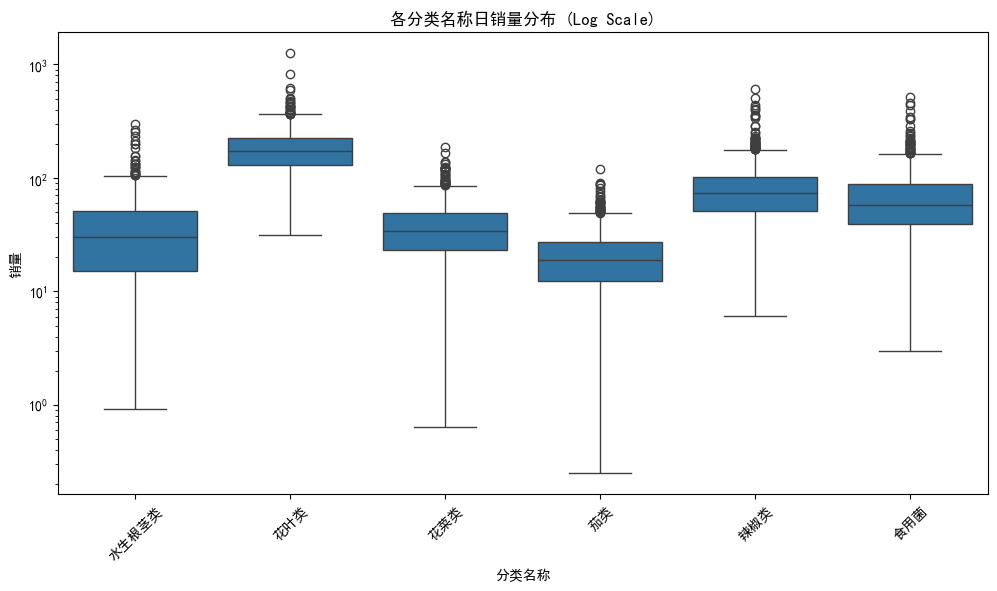

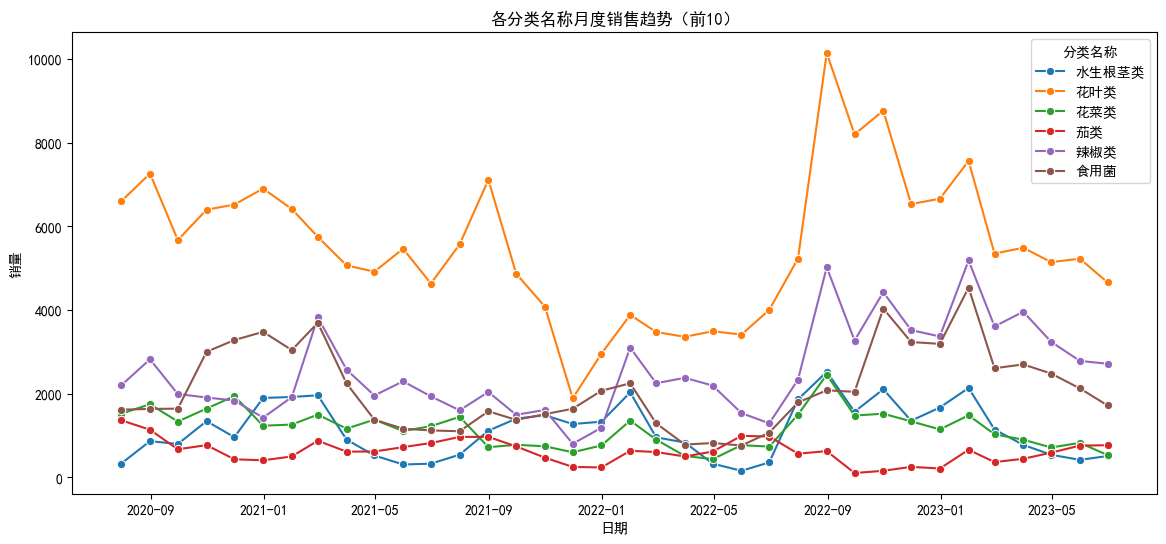

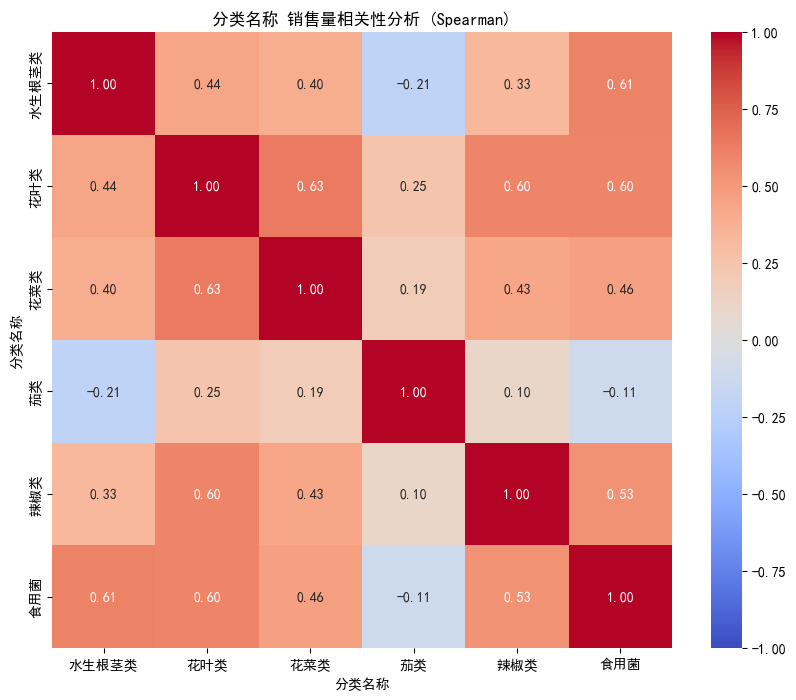

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.



--- 2. 热门单品层面分析 (Top 10) ---


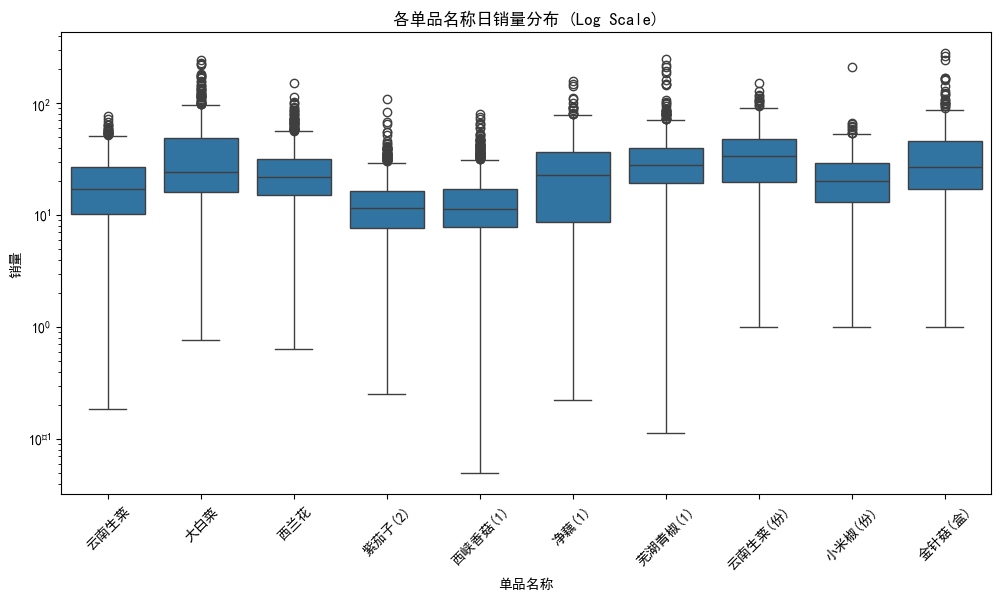

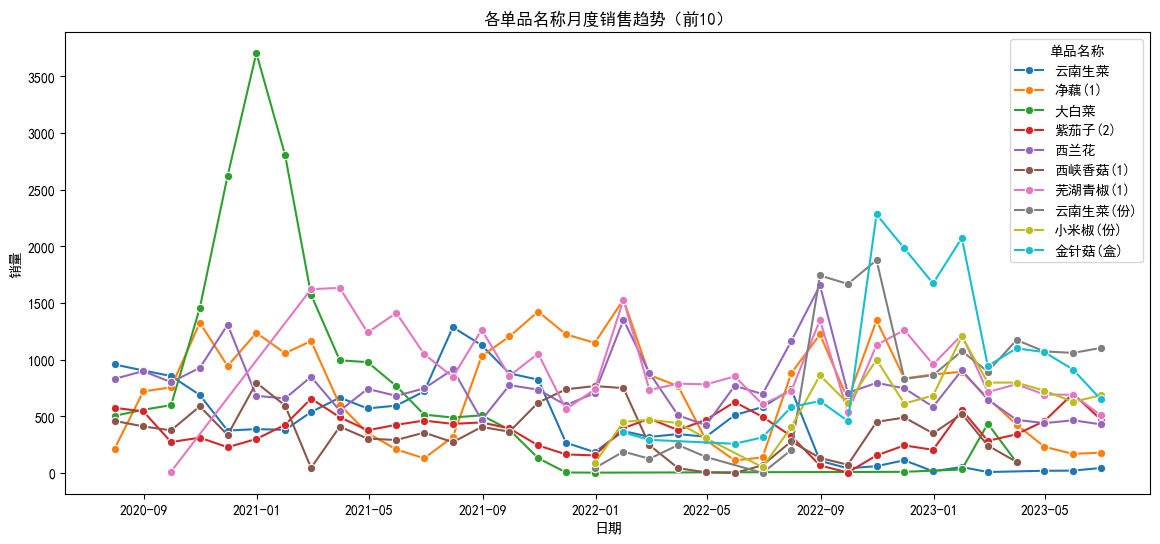

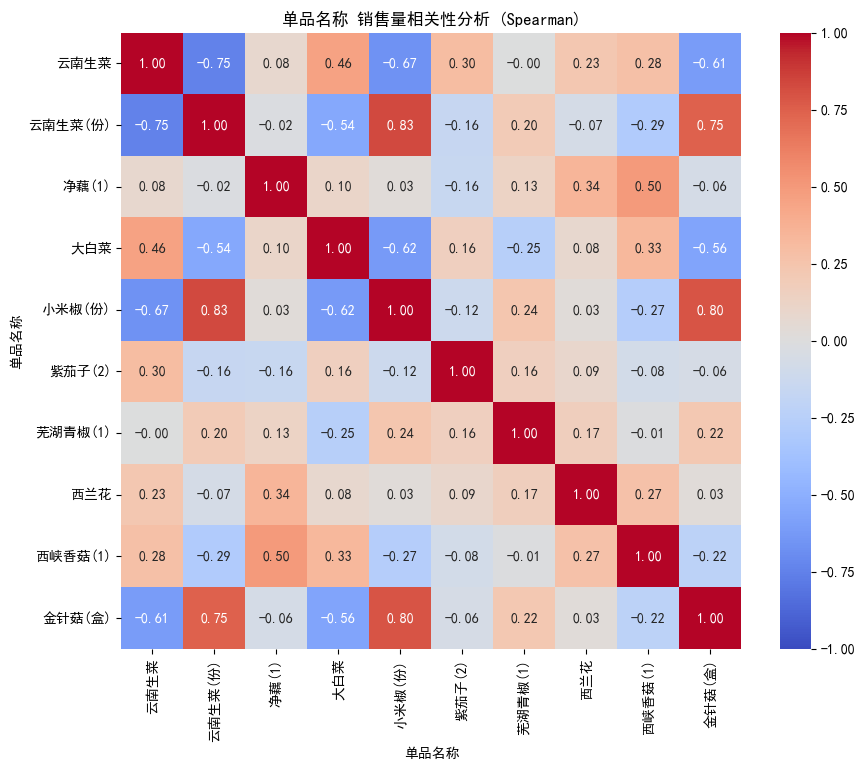

In [45]:
print("--- 1. 品类层面分析 ---")
analyze_distribution(df_cat_daily, level_name='分类名称')
corr_cat = analyze_correlation(df_cat_daily, level_name='分类名称')

print("\n--- 2. 热门单品层面分析 (Top 10) ---")
# 单品太多，只分析销量前10名，否则热力图看不清
top_skus = df_sku_daily.groupby('单品名称')['销量'].sum().nlargest(10).index
df_top_sku = df_sku_daily[df_sku_daily['单品名称'].isin(top_skus)]

analyze_distribution(df_top_sku, level_name='单品名称')
corr_sku = analyze_correlation(df_top_sku, level_name='单品名称')

In [46]:
print("单品销量前十:")
sales_by_cat = df_sku_daily.groupby('单品名称')['销量'].sum().sort_values(ascending=False)
for cat, sales in sales_by_cat.head(10).items():
    print(f"  {cat}: {sales:,.1f}kg")

单品销量前十:
  芜湖青椒(1): 28,181.7kg
  西兰花: 27,555.9kg
  净藕(1): 27,166.5kg
  大白菜: 19,196.1kg
  云南生菜: 15,915.4kg
  金针菇(盒): 15,602.0kg
  云南生菜(份): 14,335.0kg
  紫茄子(2): 13,609.0kg
  西峡香菇(1): 11,929.1kg
  小米椒(份): 10,847.0kg


In [47]:
# 文字统计报告
def generate_text_report(df_sku_daily, df_cat_daily):
    print(" === 蔬菜销售数据统计报告 ===\n")
    
    # --- 1. 单品销售 TOP 10 ---
    print(" [单品销量 TOP 10]")
    # 按单品名称汇总总销量
    top_10 = df_sku_daily.groupby('单品名称')['销量'].sum().nlargest(10)
    for i, (name, sales) in enumerate(top_10.items(), 1):
        # 顺便算出它占总销量的百分比
        total_sales = df_sku_daily['销量'].sum()
        share = (sales / total_sales) * 100
        print(f"   NO.{i}: {name:<10} 销量: {sales:,.0f} kg (占比 {share:.2f}%)")
    print("-" * 40)

    # --- 2. 品类年度分析 (Yearly Analysis) ---
    print("\n [各品类年度销量概览]")
    #透视表：行=品类，列=年份，值=销量
    yearly_pivot = df_cat_daily.pivot_table(index='分类名称', columns='年份', values='销量', aggfunc='sum')
    # 填充NaN并格式化输出
    print(yearly_pivot.fillna(0).round(1))
    print("-" * 40)

    # --- 3. 季节性分析 (Quarterly Analysis) ---
    print("\n [各品类季度热度分析 (日均销量)]")
    # 我们看“日均销量”而不是总销量，因为不同季度天数可能略有不同
    quarterly_pivot = df_cat_daily.pivot_table(index='分类名称', columns='季节', values='销量', aggfunc='mean')
    print(quarterly_pivot.round(1))
    print("   (注: 采用气象季节划分，春=3-5月, 夏=6-8月, 秋=9-11月, 冬=12-2月)")
    print("-" * 40)

    # --- 4. 周末效应分析 (Weekend Effect) ---
    print("\n [周末 vs 工作日 销量对比]")
    # 计算周末和工作日的平均销量
    weekend_analysis = df_cat_daily.groupby(['分类名称', '是否周末'])['销量'].mean().unstack()
    weekend_analysis.columns = ['工作日均值', '周末均值']
    # 计算周末带来的“提升率”
    weekend_analysis['周末提升率'] = (weekend_analysis['周末均值'] - weekend_analysis['工作日均值']) / weekend_analysis['工作日均值']
    
    # 格式化打印
    print(f"{'分类名称':<10} {'工作日均值':<10} {'周末均值':<10} {'提升率'}")
    for cat in weekend_analysis.index:
        row = weekend_analysis.loc[cat]
        print(f"{cat:<10} {row['工作日均值']:<10.1f} {row['周末均值']:<10.1f} {row['周末提升率']:+.2%}")
        
    print("\n   💡 导师点评: 若提升率为正，说明该品类适合在周末加大备货。")


generate_text_report(df_sku_daily, df_cat_daily)

 === 蔬菜销售数据统计报告 ===

 [单品销量 TOP 10]
   NO.1: 芜湖青椒(1)    销量: 28,182 kg (占比 5.98%)
   NO.2: 西兰花        销量: 27,556 kg (占比 5.85%)
   NO.3: 净藕(1)      销量: 27,166 kg (占比 5.76%)
   NO.4: 大白菜        销量: 19,196 kg (占比 4.07%)
   NO.5: 云南生菜       销量: 15,915 kg (占比 3.38%)
   NO.6: 金针菇(盒)     销量: 15,602 kg (占比 3.31%)
   NO.7: 云南生菜(份)    销量: 14,335 kg (占比 3.04%)
   NO.8: 紫茄子(2)     销量: 13,609 kg (占比 2.89%)
   NO.9: 西峡香菇(1)    销量: 11,929 kg (占比 2.53%)
   NO.10: 小米椒(份)     销量: 10,847 kg (占比 2.30%)
----------------------------------------

 [各品类年度销量概览]
年份        2020     2021     2022     2023
分类名称                                     
水生根茎类   6203.0  13110.5  15761.2   5533.0
花叶类    39352.4  58724.8  67151.9  33430.5
花菜类     9433.0  12701.9  14163.2   5491.7
茄类      4790.9   7798.7   6259.7   3592.8
辣椒类    12192.2  23256.9  34702.2  21493.8
食用菌    14661.4  21934.4  23362.4  16173.5
----------------------------------------

 [各品类季度热度分析 (日均销量)]
季节        春季     夏季     秋季     冬季
分类名称                      

In [54]:
quarterly = df_cat_daily.groupby(['季节', '分类名称']).agg({
    '销量': 'mean'  # 季度日均销量
}).reset_index()

season_desc = {
    '春季': '春季(3-5月)',
    '夏季': '夏季(6-8月)',
    '秋季': '秋季(9-11月)',
    '冬季': '冬季(12-2月)'
}

print("\n [各季节平均日销量 TOP 3]")
for season in ["春季", "夏季", "秋季", "冬季"]:
    season_data = quarterly[quarterly['季节'] == season]
    if season_data.empty: continue
    
    print(f"\n{season_desc[season]}:")
    for _, row in season_data.sort_values('销量', ascending=False).head(3).iterrows():
        print(f"   {row['分类名称']}: {row['销量']:.1f} kg/天")


print("\n [季节性波动分析（旺季/淡季）]")
for cat in quarterly['分类名称'].unique():
    cat_data = quarterly[quarterly['分类名称'] == cat]
    if cat_data.empty: continue
    
    # 找到最大值和最小值所在的行
    peak = cat_data.loc[cat_data['销量'].idxmax()]
    low = cat_data.loc[cat_data['销量'].idxmin()]
    
    # 计算差异百分比
    if low['销量'] > 0:
        diff = (peak['销量'] - low['销量']) / low['销量'] * 100
    else:
        diff = float('inf') # 避免除以零

    peak_str = season_desc.get(peak['季节'], peak['季节'])
    low_str = season_desc.get(low['季节'], low['季节'])
    
    print(f"   {cat:<6}: 旺季 [{peak_str}], 淡季 [{low_str}], 波动幅度 {diff:+.0f}%")


 [各季节平均日销量 TOP 3]

春季(3-5月):
   花叶类: 150.6 kg/天
   辣椒类: 83.1 kg/天
   食用菌: 52.4 kg/天

夏季(6-8月):
   花叶类: 200.0 kg/天
   辣椒类: 79.6 kg/天
   食用菌: 49.7 kg/天

秋季(9-11月):
   花叶类: 196.0 kg/天
   食用菌: 80.6 kg/天
   辣椒类: 77.3 kg/天

冬季(12-2月):
   花叶类: 186.1 kg/天
   食用菌: 99.5 kg/天
   辣椒类: 98.4 kg/天

 [季节性波动分析（旺季/淡季）]
   水生根茎类 : 旺季 [冬季(12-2月)], 淡季 [春季(3-5月)], 波动幅度 +229%
   花叶类   : 旺季 [夏季(6-8月)], 淡季 [春季(3-5月)], 波动幅度 +33%
   花菜类   : 旺季 [夏季(6-8月)], 淡季 [春季(3-5月)], 波动幅度 +52%
   茄类    : 旺季 [夏季(6-8月)], 淡季 [秋季(9-11月)], 波动幅度 +83%
   辣椒类   : 旺季 [冬季(12-2月)], 淡季 [秋季(9-11月)], 波动幅度 +27%
   食用菌   : 旺季 [冬季(12-2月)], 淡季 [夏季(6-8月)], 波动幅度 +100%


## 相关分析

In [37]:
from scipy import stats

def analyze_price_elasticity_report(df_daily, level_name='分类名称'):
    """
    计算各品类/单品的价格与销量的 Spearman 相关性，并生成详细文字报告
    """
    print(f"📊 === {level_name} 价格-销量 Spearman 相关性分析 ===\n")
    
    results = []
    categories = df_daily[level_name].unique()
    
    for cat in categories:
        sub_df = df_daily[df_daily[level_name] == cat].copy()
        if len(sub_df) < 10:  # 样本太少不计算
            continue
            
        r, p_value = stats.spearmanr(sub_df['加权单价'], sub_df['销量'])

        significance = "显著" if p_value < 0.05 else "不显著"
        abs_r = abs(r)
        if abs_r > 0.7:
            strength = "强"
        elif abs_r > 0.3:
            strength = "中等"
        else:
            strength = "弱"
            
        # 判断方向
        direction = "负相关" if r < 0 else "正相关"
        
        results.append({
            level_name: cat,
            'Spearman系数': r,
            'p值': p_value,
            '显著性': significance,
            '强度': strength,
            '方向': direction
        })
    
    # 转为 DataFrame 并按相关系数排序 (负相关越强越靠前)
    res_df = pd.DataFrame(results).sort_values('Spearman系数')
    

    # 设置 pandas 显示参数以便在 Notebook 中看清
    print(f"{'分类名称':<12} {'Spearman系数':<15} {'p值':<10} {'显著性':<8} {'强度':<8} {'方向'}")
    print("-" * 70)
    for index, row in res_df.iterrows():
        print(f"{row[level_name]:<12} {row['Spearman系数']:<15.3f} {row['p值']:<10.3f} {row['显著性']:<8} {row['强度']:<8} {row['方向']}")
    
    print("-" * 70)
    
    significant_items = res_df[res_df['p值'] < 0.05]
    
    if not significant_items.empty:
        print("显著相关的品类 (p < 0.05):")
        
        # 按强度分组输出
        for strength_level in ['强', '中等', '弱']:
            items = significant_items[significant_items['强度'] == strength_level]
            if not items.empty:
                print(f"  {strength_level}{items.iloc[0]['方向']}:") # 例如：中等负相关
                for _, row in items.iterrows():
                    print(f"    - {row[level_name]}: r={row['Spearman系数']:.3f}, p={row['p值']:.3f}")
    else:
        print("  未发现显著的相关关系。")

    print("\n   💡 导师点评: 负相关系数绝对值越大，说明该商品对价格越敏感（涨价一点点，销量就掉很多）。")
    print("                这对问题2的定价策略至关重要：'食用菌'和'水生根茎类'不能轻易涨价！")
    
    return res_df


elasticity_df = analyze_price_elasticity_report(df_cat_daily, level_name='分类名称')

📊 === 分类名称 价格-销量 Spearman 相关性分析 ===

分类名称         Spearman系数      p值         显著性      强度       方向
----------------------------------------------------------------------
水生根茎类        -0.543          0.000      显著       中等       负相关
辣椒类          -0.402          0.000      显著       中等       负相关
食用菌          -0.319          0.000      显著       中等       负相关
茄类           -0.313          0.000      显著       中等       负相关
花菜类          -0.282          0.000      显著       弱        负相关
花叶类          -0.186          0.000      显著       弱        负相关
----------------------------------------------------------------------
显著相关的品类 (p < 0.05):
  中等负相关:
    - 水生根茎类: r=-0.543, p=0.000
    - 辣椒类: r=-0.402, p=0.000
    - 食用菌: r=-0.319, p=0.000
    - 茄类: r=-0.313, p=0.000
  弱负相关:
    - 花菜类: r=-0.282, p=0.000
    - 花叶类: r=-0.186, p=0.000

   💡 导师点评: 负相关系数绝对值越大，说明该商品对价格越敏感（涨价一点点，销量就掉很多）。
                这对问题2的定价策略至关重要：'食用菌'和'水生根茎类'不能轻易涨价！
